In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from datasets.cityscapes import Cityscapes
from datasets.bdd100k import BDD100KSeg
from datasets.road_anomaly import RoadAnomaly
from datasets.fishyscapes import FishyscapesLAF, FishyscapesStatic
from datasets.segment_me_if_you_can import RoadAnomaly21, RoadObstacle21
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm

from train_net import Trainer, setup
from detectron2.checkpoint import DetectionCheckpointer


from analysis.max_logits import MaxLogitsAnalyzer, OODEvaluator

# Paths

Here subscript $bi$ refers to the $i^{th}$ checkpoint before the last. This means that b1 is the checkpoint that was saved right before the final one was saved and so on. A checkpoint is saved every 5000 iterations.

In [4]:
config_path = 'model_logs/mask2former_per_pixel/config.yaml'
ckpt_path = 'model_logs/mask2former_per_pixel/model_0039999.pth'
ckpt_path_b1 = 'model_logs/mask2former_per_pixel/model_0034999.pth'
ckpt_path_b2 = 'model_logs/mask2former_per_pixel/model_0029999.pth'
ckpt_path_b3 = 'model_logs/mask2former_per_pixel/model_0024999.pth'
ckpt_path_b4 = 'model_logs/mask2former_per_pixel/model_0019999.pth'
ckpt_path_b5 = 'model_logs/mask2former_per_pixel/model_0014999.pth'
ckpt_path_b6 = 'model_logs/mask2former_per_pixel/model_0009999.pth'
ckpt_path_b7 = 'model_logs/mask2former_per_pixel/model_0004999.pth'

ckpt_paths = {
    'final': ckpt_path,
    'b0': ckpt_path,
    'b1': ckpt_path_b1,
    'b2': ckpt_path_b2,
    'b3': ckpt_path_b3,
    'b4': ckpt_path_b4,
    'b5': ckpt_path_b5,
    'b6': ckpt_path_b6,
    'b7': ckpt_path_b7
}


# Loading the Model

In [5]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

def get_model(name='final'):
    
    args = edict({'config_file': config_path, 'eval-only':True, 'opts':[]})
    config = setup(args)

    model = Trainer.build_model(config)
    DetectionCheckpointer(model, save_dir=config.OUTPUT_DIR).resume_or_load(
        ckpt_paths[name], resume=False
    )
    model.cuda()
    _ = model.eval()
    
    return model


In [13]:
model = get_model('b1')

[09/01 13:07:34 detectron2]: Rank of current process: 0. World size: 1
[09/01 13:07:34 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   /home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch=8.6)
Driver version          510.85.

[09/01 13:07:34 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 6
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[09/01 13:07:34 detectron2]: Full config saved to ./model_logs/mask2former_per_pixel/config.yaml
[09/01 13:07:34 d2.utils.env]: Using a generated random seed 35052456
[09/01 13:07:35 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softma

[09/01 13:07:35 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_per_pixel/model_0034999.pth ...


# Dataset Configs

In [7]:
bdd100k_config = edict({
    'seg_downsample_rate': 1,
    'train_file': 'train_paths.txt',
    'val_file': 'val_paths.txt',
    'val_image_strategy': 'no_change',
    'ignore_train_class': True,
    'dataset_root': '/home/user/datasets/bdd100k/seg'
})

cityscapes_config = edict({
    'dataset_root': '/home/user/datasets/cityscapes',
})

road_anomaly_config = edict({
    'dataset_root': '/home/user/datasets/RoadAnomaly/RoadAnomaly_jpg',
    'test_image_strategy': 'no_change'
})

fishyscapes_laf_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

fishyscapes_static_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

road_anomaly_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_AnomalyTrack',
    'dataset_mode': 'all'
})

road_obstacle_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_ObstacleTrack',
    'dataset_mode': 'all'
})



# Create Datasets

In [8]:
# Cityscapes
transform = A.Compose([
    ToTensorV2()
])
cityscapes_dataset = Cityscapes(cityscapes_config, transform=transform, split='val', 
                                target_type='semantic')
loader_cityscapes = DataLoader(cityscapes_dataset, batch_size=1, shuffle=False, num_workers=15)

# BDD100K
transform_bdd100k = A.Compose([
    ToTensorV2(),
])
bdd100k_dataset = BDD100KSeg(hparams=bdd100k_config, mode='val', transforms=transform_bdd100k, 
                             image_size=(720, 1280))
loader_bdd100k = DataLoader(bdd100k_dataset, batch_size=1, shuffle=False, num_workers=15)
# Road Anomaly
transform_road_anomaly = A.Compose([
    ToTensorV2()
])
road_anomaly_dataset = RoadAnomaly(hparams=road_anomaly_config, transforms=transform_road_anomaly)
loader_road_anomaly = DataLoader(road_anomaly_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes LaF
transform_fs_laf = A.Compose([
    ToTensorV2()
])
fs_laf_dataset = FishyscapesLAF(hparams=fishyscapes_laf_config, transforms=transform_fs_laf)
loader_fs_laf = DataLoader(fs_laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes Static
transform_fs_static = A.Compose([
    ToTensorV2()
])
fs_static_dataset = FishyscapesStatic(hparams=fishyscapes_static_config, transforms=transform_fs_static)
loader_fs_static = DataLoader(fs_static_dataset, batch_size=1, shuffle=False, num_workers=15)

# Road Anomaly 21
transform_ra_21 = A.Compose([
    A.Resize(height=720, width=1280),
    ToTensorV2()
])
road_anomaly_21_dataset = RoadAnomaly21(hparams=road_anomaly_21_config, transforms=transform_ra_21)
loader_road_anomaly_21 = DataLoader(road_anomaly_21_dataset, batch_size=1, shuffle=False, num_workers=15)


# Util Functions

In [9]:
def get_logits(model, x, **kwargs):
    
    with torch.no_grad():
        out = model([{"image": x[0].cuda()}])
        
    return out[0]['sem_seg'].unsqueeze(0)

# Identify Output Stats from Different Sections

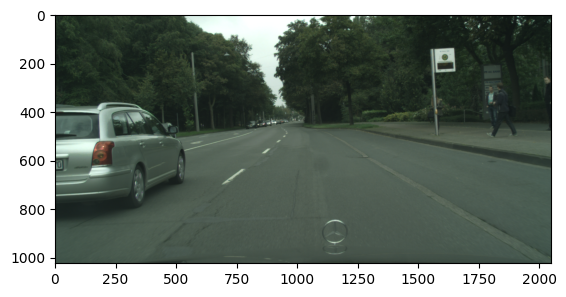

In [10]:
img, lbl = cityscapes_dataset[1]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [14]:
logits = get_logits(model, img).squeeze()

Output Conv Pixel Decoder: (Min, Max, Mean, STD)  -0.11219462007284164 0.12788264453411102 9.413457155460492e-05 0.02174885757267475
Y Output Pixel Decoder: (Min, Max, Mean, STD)  0.0 10.822834968566895 1.0085190534591675 1.6766180992126465
Pixel Decoder Out Entry 0: (Min, Max, Mean, STD)  -4.050812721252441 3.9678072929382324 5.1177688874304295e-05 1.0369292497634888
Pixel Decoder Out Entry 1: (Min, Max, Mean, STD)  -3.9415714740753174 4.023720741271973 5.290529952617362e-05 1.0370396375656128
Pixel Decoder Out Entry 2: (Min, Max, Mean, STD)  -4.396979331970215 4.453744888305664 4.3016210838686675e-05 1.036958932876587
Pixel Decoder Out Entry 3: (Min, Max, Mean, STD)  0.0 10.822834968566895 1.0085190534591675 1.6766180992126465
Mask Features Conv Layer: (Min, Max, Mean, STD)  -0.5095466375350952 0.47702261805534363 -9.185912495013326e-05 0.09641479700803757
Pixel Decoder Mask Features stats: (Min, Max, Mean, STD)  -88.72968292236328 92.52835845947266 -0.04794948548078537 30.9614677429

In [11]:
logits = get_logits(model, img).squeeze()

/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Output Conv Pixel Decoder: (Min, Max, Mean, STD)  -0.11279786378145218 0.13197584450244904 0.0001076434928108938 0.021801216527819633
Y Output Pixel Decoder: (Min, Max, Mean, STD)  0.0 18.67560386657715 1.0008400678634644 1.7251147031784058
Pixel Decoder Out Entry 0: (Min, Max, Mean, STD)  -4.238584518432617 4.339992046356201 4.9768161261454225e-05 1.0394980907440186
Pixel Decoder Out Entry 1: (Min, Max, Mean, STD)  -4.524648189544678 4.552675724029541 2.5110100978054106e-05 1.0396534204483032
Pixel Decoder Out Entry 2: (Min, Max, Mean, STD)  -4.294161796569824 4.735300064086914 -1.6639118257444352e-05 1.0397640466690063
Pixel Decoder Out Entry 3: (Min, Max, Mean, STD)  0.0 18.67560386657715 1.0008400678634644 1.7251147031784058
Mask Features Conv Layer: (Min, Max, Mean, STD)  -0.5090975165367126 0.48486682772636414 -9.171085548587143e-05 0.09841567277908325
Pixel Decoder Mask Features stats: (Min, Max, Mean, STD)  -148.3356475830078 153.5636444091797 -0.0641537755727768 31.16553497314

In [12]:
logits.min(), logits.max(), logits.mean(), logits.std()

(tensor(1706.7963, device='cuda:0'),
 tensor(42190.5977, device='cuda:0'),
 tensor(17320.3652, device='cuda:0'),
 tensor(3981.1248, device='cuda:0'))

In [13]:
object_queries = model.sem_seg_head.predictor.query_feat.weight

In [20]:
object_queries.std()

tensor(0.9985, device='cuda:0', grad_fn=<StdBackward>)

# Explore Outputs

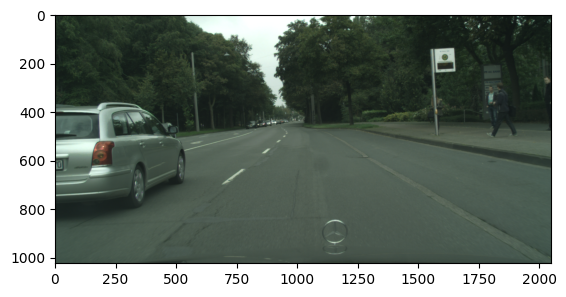

In [70]:
img, lbl = cityscapes_dataset[1]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [71]:
logits = get_logits(model, img).squeeze()

In [72]:
logits = torch.log(logits)
mn = logits.min()
mx = logits.max()
logits = (logits - mn) / (mx - mn)

In [73]:
logits.min(), logits.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

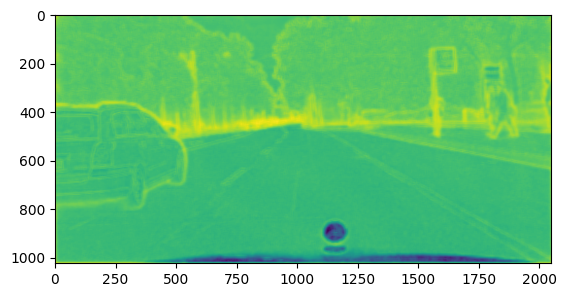

In [82]:
plt.imshow(logits[17].cpu())
plt.show()

In [18]:
logits.min()

tensor(1., device='cuda:0')

In [61]:
torch.tanh(logits[0].cpu()).min()

tensor(1.)

In [83]:
max_logits, pred = logits.max(dim=0)

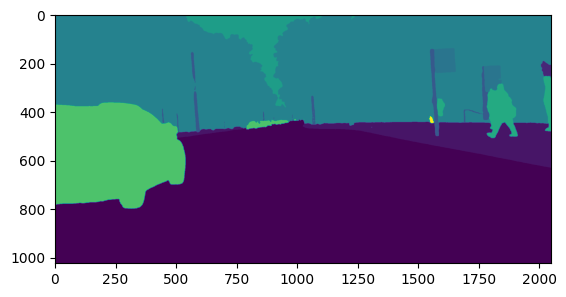

In [84]:
plt.imshow(pred.cpu())

In [54]:
mins = []
maxs = []
means = []
stds = []
for i in tqdm(range(8)):
    
    m = get_model(f'b{i}')
    
    l = get_logits(m, img).squeeze().cpu()
    
    mins.append(l.min().item())
    maxs.append(l.max().item())
    means.append(l.mean().item())
    stds.append(l.std().item())

  0%|          | 0/8 [00:00<?, ?it/s]

[08/29 15:21:39 detectron2]: Rank of current process: 0. World size: 1
[08/29 15:21:39 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch=8.6)
Driver version          515.65.01
CUDA_HOME               /usr/local/cuda
Pillow                  9.2.0
torchvision     

[08/29 15:21:39 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 6
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[08/29 15:21:39 detectron2]: Full config saved to ./model_logs/mask2former_per_pixel/config.yaml
[08/29 15:21:39 d2.utils.env]: Using a generated random seed 39672011
[08/29 15:21:40 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softma

[08/29 15:21:40 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_per_pixel/model_0039999.pth ...
[08/29 15:21:40 detectron2]: Rank of current process: 0. World size: 1
[08/29 15:21:41 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch

[08/29 15:21:41 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 6
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[08/29 15:21:41 detectron2]: Full config saved to ./model_logs/mask2former_per_pixel/config.yaml
[08/29 15:21:41 d2.utils.env]: Using a generated random seed 41385347
[08/29 15:21:42 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softma

[08/29 15:21:42 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_per_pixel/model_0034999.pth ...
[08/29 15:21:42 detectron2]: Rank of current process: 0. World size: 1
[08/29 15:21:42 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch

[08/29 15:21:42 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 6
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[08/29 15:21:42 detectron2]: Full config saved to ./model_logs/mask2former_per_pixel/config.yaml
[08/29 15:21:43 d2.utils.env]: Using a generated random seed 43108081
[08/29 15:21:43 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softma

[08/29 15:21:43 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_per_pixel/model_0029999.pth ...
[08/29 15:21:44 detectron2]: Rank of current process: 0. World size: 1
[08/29 15:21:44 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch

[08/29 15:21:44 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 6
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[08/29 15:21:44 detectron2]: Full config saved to ./model_logs/mask2former_per_pixel/config.yaml
[08/29 15:21:44 d2.utils.env]: Using a generated random seed 44680506
[08/29 15:21:45 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softma

[08/29 15:21:45 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_per_pixel/model_0024999.pth ...
[08/29 15:21:45 detectron2]: Rank of current process: 0. World size: 1
[08/29 15:21:46 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch

[08/29 15:21:46 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 6
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[08/29 15:21:46 detectron2]: Full config saved to ./model_logs/mask2former_per_pixel/config.yaml
[08/29 15:21:46 d2.utils.env]: Using a generated random seed 46325997
[08/29 15:21:46 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softma

[08/29 15:21:46 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_per_pixel/model_0019999.pth ...
[08/29 15:21:47 detectron2]: Rank of current process: 0. World size: 1
[08/29 15:21:47 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch

[08/29 15:21:47 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 6
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[08/29 15:21:47 detectron2]: Full config saved to ./model_logs/mask2former_per_pixel/config.yaml
[08/29 15:21:47 d2.utils.env]: Using a generated random seed 48006050
[08/29 15:21:48 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softma

[08/29 15:21:48 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_per_pixel/model_0014999.pth ...
[08/29 15:21:49 detectron2]: Rank of current process: 0. World size: 1
[08/29 15:21:49 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch

[08/29 15:21:49 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 6
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[08/29 15:21:49 detectron2]: Full config saved to ./model_logs/mask2former_per_pixel/config.yaml
[08/29 15:21:49 d2.utils.env]: Using a generated random seed 49622480
[08/29 15:21:50 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softma

[08/29 15:21:50 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_per_pixel/model_0009999.pth ...
[08/29 15:21:50 detectron2]: Rank of current process: 0. World size: 1
[08/29 15:21:51 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch

[08/29 15:21:51 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 6
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[08/29 15:21:51 detectron2]: Full config saved to ./model_logs/mask2former_per_pixel/config.yaml
[08/29 15:21:51 d2.utils.env]: Using a generated random seed 51295294
[08/29 15:21:51 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softma

[08/29 15:21:51 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_per_pixel/model_0004999.pth ...


In [55]:
print(mins)
print(maxs)
print(means)
print(stds)

[1993.4697265625, 2591.644775390625, 101.78394317626953, 125.75114440917969, 311.455078125, 73.85627746582031, 4.497768402099609, -4.640442371368408]
[37747.0703125, 23792.0859375, 18414.26171875, 10991.28125, 3629.173828125, 625.8514404296875, 143.3821258544922, 52.89033889770508]
[16785.28125, 15529.7890625, 11214.10546875, 6320.90771484375, 2264.3623046875, 395.165283203125, 82.101806640625, 20.417627334594727]
[3990.268798828125, 2072.6044921875, 2371.046630859375, 1426.47314453125, 435.1643981933594, 91.58912658691406, 26.03095245361328, 9.016449928283691]
